In [1]:
from nnsight import NNsight
import torch 
from transformers import GPTJForCausalLM, AutoTokenizer 
from IPython.display import clear_output
from nnsight import LanguageModel
from typing import List, Callable
import torch
import numpy as np
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt


model_path = "/data/lmm/checkpoints/lm/lm-pretrain-only-checkpoint-1953"
gptj = GPTJForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = LanguageModel(gptj,tokenizer=tokenizer)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
model.eval()

/home/allanz/miniconda3/envs/vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50257, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTJBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (out_proj): Linear(in_features=768, out_features=768, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=768, out_features=3072, bias=True)
          (fc_out): Linear(in_features=3072, out_features=768, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((7

In [2]:
prompts = ["""| deer | cat | bird |
| deer | cat | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row {row}, column {column}? A: 
""",
"""| bird | bird | bird |
| deer | bird | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row {row}, column {column}? A: 
""",
"""| airplane | airplane | airplane |
| deer | airplane | cat |
| airplane | dog | airplane |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'airplane', 'dog', 'cat'].
What object is in row {row}, column {column}? A: 
"""]

def preds_over_layers(data, annotations, token_num):
    for pred, prob in zip([row[token_num].strip().split(" ")[0] for row in annotations], data[:, token_num]):
        print(f"{pred}, {prob:.2f}")

def probs_over_answers(probs, tokens):
    token_ids = {token: tokenizer.encode(f" {token}", add_special_tokens=False)[0] for token in tokens}
    # Extract probabilities for the specified token IDs
    token_probs = probs[:, -1, [token_ids[token] for token in tokens]]
    # Convert to numpy array for easier manipulation
    token_probs_np = token_probs.detach().cpu().numpy()
    
    # Create a mask for the maximum values in each row
    max_mask = (token_probs_np == token_probs_np.max(axis=1, keepdims=True))
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    yticklabels = [f'Layer {i//2} {"attn" if i % 2 == 0 else "mlp"}' for i in range(token_probs_np.shape[0])]
    ax = sns.heatmap(token_probs_np, 
                     xticklabels=tokens, 
                     yticklabels=yticklabels, 
                     cmap='viridis', 
                     annot=True,
                     fmt=".2f",
                     linewidths=0.5,
                     linecolor='black')
    
    # Add red outline around the maximum values in each row
    for y in range(token_probs_np.shape[0]):
        for x in range(token_probs_np.shape[1]):
            if max_mask[y, x]:
                ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=3))
    
    plt.xlabel('Tokens')
    plt.ylabel('Layers')
    plt.title('Average Probabilities over Layers for Each Token')
    plt.show()
    
    
def access_prompt (prompt_index, row, column):
    return prompts[prompt_index].format(row=row, column=column)

ANIMALS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
def logit_look(prompt_index, row, column, print_prompt=True, plot=True):
    prompt = access_prompt(prompt_index, row, column)
    
    if print_prompt:
        print(prompt)
    layers = model.transformer.h

    probs_layers = []

    with model.trace() as tracer:
        with tracer.invoke(prompt) as invoker:
            for layer_idx, layer in enumerate(layers):
                # Process layer output through the model's head and layer normalization
                attn_output = model.lm_head(model.transformer.ln_f(layer.attn.output[0]))
                mlp_output = model.lm_head(model.transformer.ln_f(layer.output[0]))

                # Apply softmax to obtain probabilities and save the result
                attn_probs = torch.nn.functional.softmax(attn_output, dim=-1).save()
                mlp_probs = torch.nn.functional.softmax(mlp_output, dim=-1).save()
                probs_layers.append(attn_probs)
                probs_layers.append(mlp_probs)

    probs = torch.cat([probs.value for probs in probs_layers])
    probs = probs[:,:64,:]
    probs_over_answers(probs, ANIMALS)
    
    
    # Find the maximum probability and corresponding tokens for each position
    max_probs, tokens = probs.max(dim=-1)
    # Decode token IDs to words for each layer
    words = [[model.tokenizer.decode(t.cpu()).encode("unicode_escape").decode() for t in layer_tokens]
        for layer_tokens in tokens]
    print(tokens[11][-1].item(), words[11][-1])
    # Access the 'input_ids' attribute of the invoker object to get the input words
    input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]

    data = max_probs.detach().cpu().numpy()[:, :64]  
    cutoff = [layer[:64] for layer in words]  

    annotations = []
    for layer_idx, layer_words in enumerate(cutoff):  
        annotation_layer = []
        for token_idx, word in enumerate(layer_words): 
            prob = data[layer_idx, token_idx]
            annotation_layer.append(f"{word} \n {prob * 100:.4f}%")
        annotations.append(annotation_layer)  

    if plot:
        plt.figure(figsize=(128, 12))  

        ax = sns.heatmap(data,  # Only show the last column
                        annot=annotations,  # Only annotate the last column
                        fmt='s',
                        cmap='coolwarm',
                        annot_kws={"size": 10},
                        cbar_kws={'label': 'Probability'},
                        cbar=True,
                        )


        plt.xlabel("Input Tokens", fontsize=30)  
        plt.ylabel("Layers", fontsize=30)  

        ax.set_xticks([x + 0.5 for x in range(len(input_words[:64]))])  
        ax.set_xticklabels(input_words[:64], fontsize=20, ha='center')  

        plt.yticks(rotation=0, fontsize=30)  

        plt.savefig("logit_lens_plot.png", dpi=75, bbox_inches='tight')
        plt.show()
    
    if print_prompt:
        print(f"Model predicts{data[-1][-1] * 100 : 4f}% chance answer is{cutoff[-1][-1]}")
    
    preds_over_layers(data, annotations, -1)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


| airplane | airplane | airplane |
| deer | airplane | cat |
| airplane | dog | airplane |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'airplane', 'dog', 'cat'].
What object is in row 1, column 0? A: 



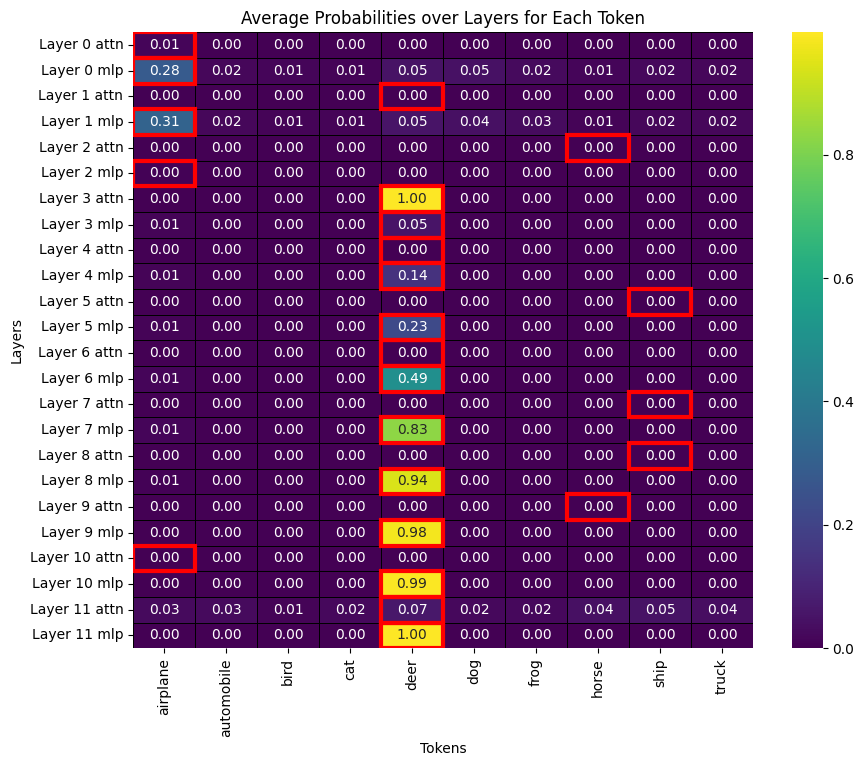

323  deer
Model predicts 99.863118% chance answer is deer
airplane, 0.01
airplane, 0.28
?, 0.00
airplane, 0.31
bird, 0.00
airplane, 0.00
deer, 1.00
deer, 0.05
airplane, 0.02
deer, 0.14
in, 0.00
deer, 0.23
cat, 0.19
deer, 0.49
automobile, 0.53
deer, 0.83
., 0.03
deer, 0.94
The, 0.22
deer, 0.98
|, 0.01
deer, 0.99
',, 0.27
deer, 1.00


In [3]:
logit_look(prompt_index=2, row=1, column=0, print_prompt=True, plot=False)

| deer | cat | bird |
| deer | cat | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row {row}, column {column}? A: 

0 0


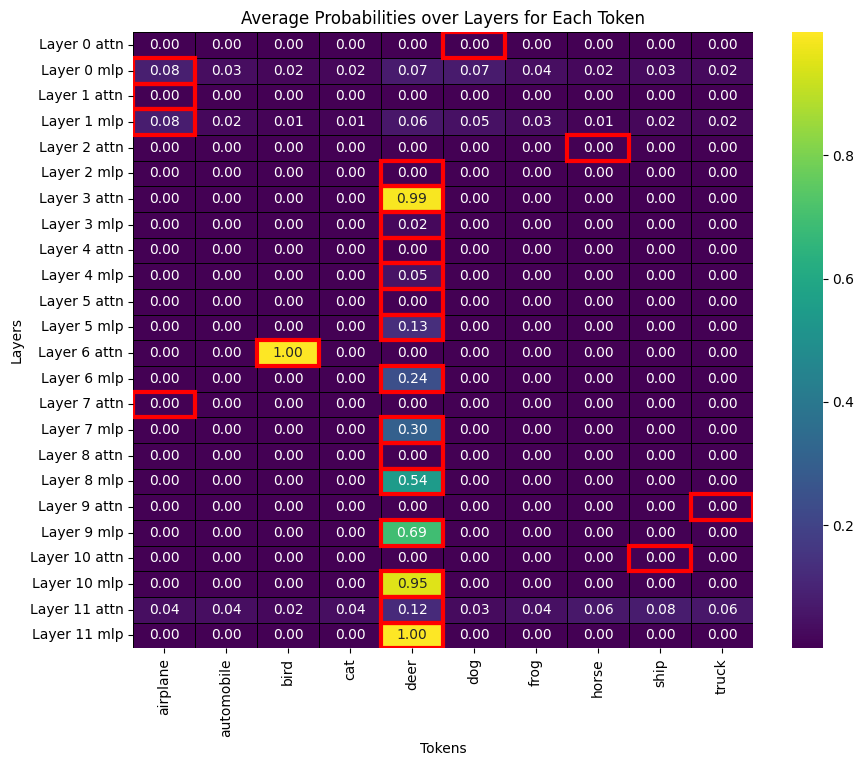

323  deer
1, 0.01
airplane, 0.08
?, 0.00
airplane, 0.08
Each, 0.00
deer, 0.00
deer, 0.99
deer, 0.02
bird, 0.01
deer, 0.05
in, 0.62
deer, 0.13
bird, 1.00
deer, 0.24
\n, 0.03
deer, 0.30
., 0.11
deer, 0.54
The, 0.00
deer, 0.69
?, 0.08
deer, 0.95
,, 0.15
deer, 1.00
0 1


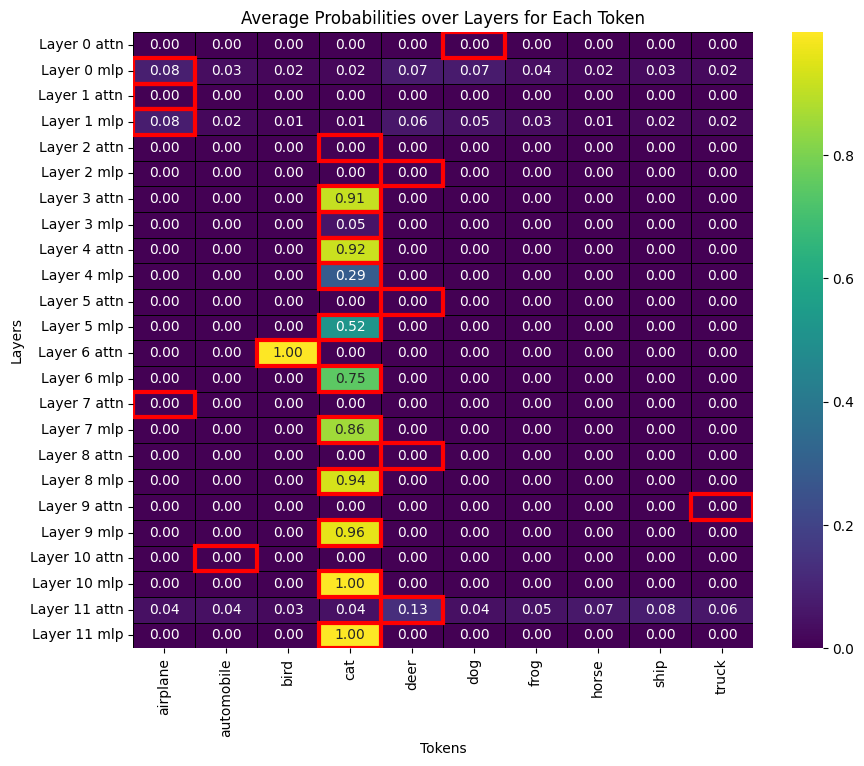

326  cat
1, 0.01
airplane, 0.08
?, 0.00
airplane, 0.08
from, 0.00
deer, 0.00
cat, 0.91
cat, 0.05
cat, 0.92
cat, 0.29
in, 0.06
cat, 0.52
bird, 1.00
cat, 0.75
Each, 0.08
cat, 0.86
., 0.82
cat, 0.94
The, 0.00
cat, 0.96
?, 0.17
cat, 1.00
',, 0.19
cat, 1.00
0 2


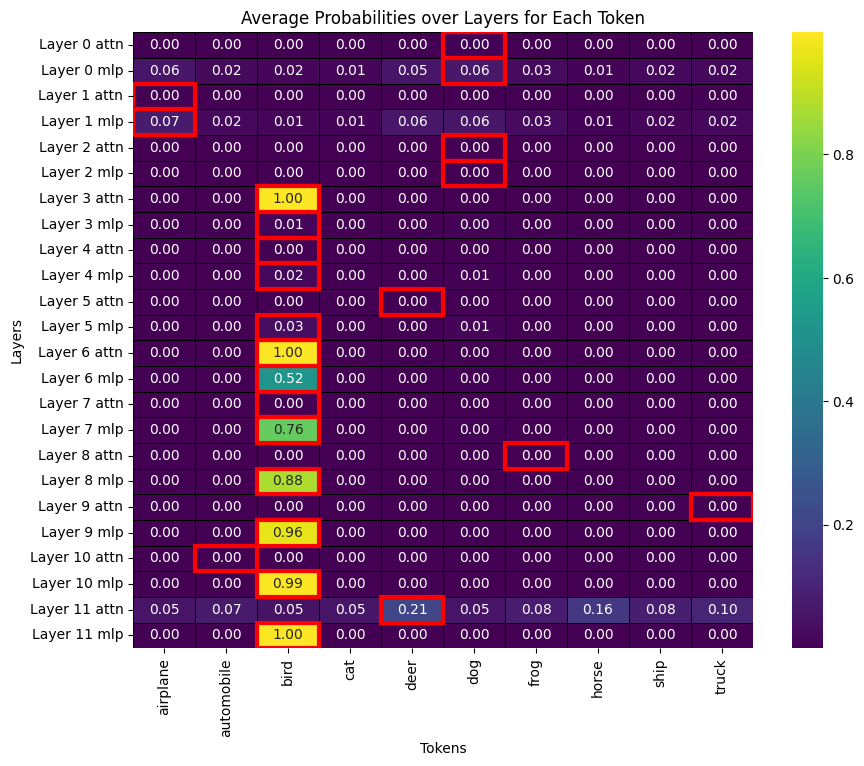

319  bird
1, 0.01
dog, 0.06
?, 0.00
airplane, 0.07
Each, 0.00
dog, 0.00
bird, 1.00
bird, 0.01
']., 0.00
bird, 0.02
in, 0.03
bird, 0.03
bird, 1.00
bird, 0.52
\n, 0.11
bird, 0.76
?, 0.08
bird, 0.88
cell, 0.46
bird, 0.96
object, 0.01
bird, 0.99
deer, 0.21
bird, 1.00
1 0


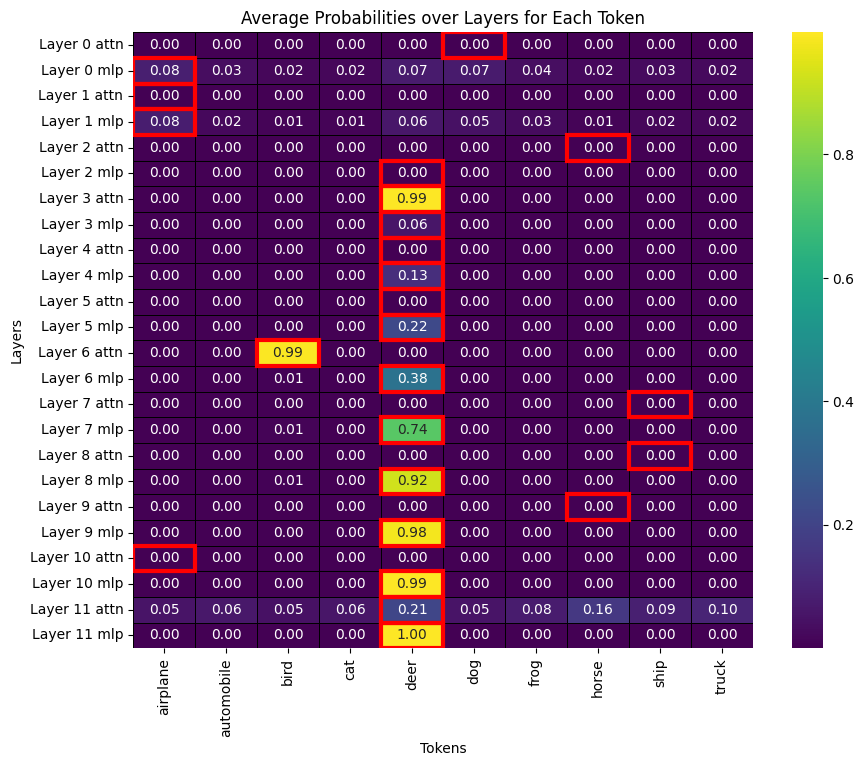

323  deer
1, 0.01
airplane, 0.08
?, 0.00
airplane, 0.08
bird, 0.00
deer, 0.00
deer, 0.99
deer, 0.06
object, 0.00
deer, 0.13
<|endoftext|>, 0.00
deer, 0.22
bird, 0.99
deer, 0.38
automobile, 0.45
deer, 0.74
horse, 0.02
deer, 0.92
The, 0.41
deer, 0.98
|, 0.01
deer, 0.99
deer, 0.21
deer, 1.00
1 1


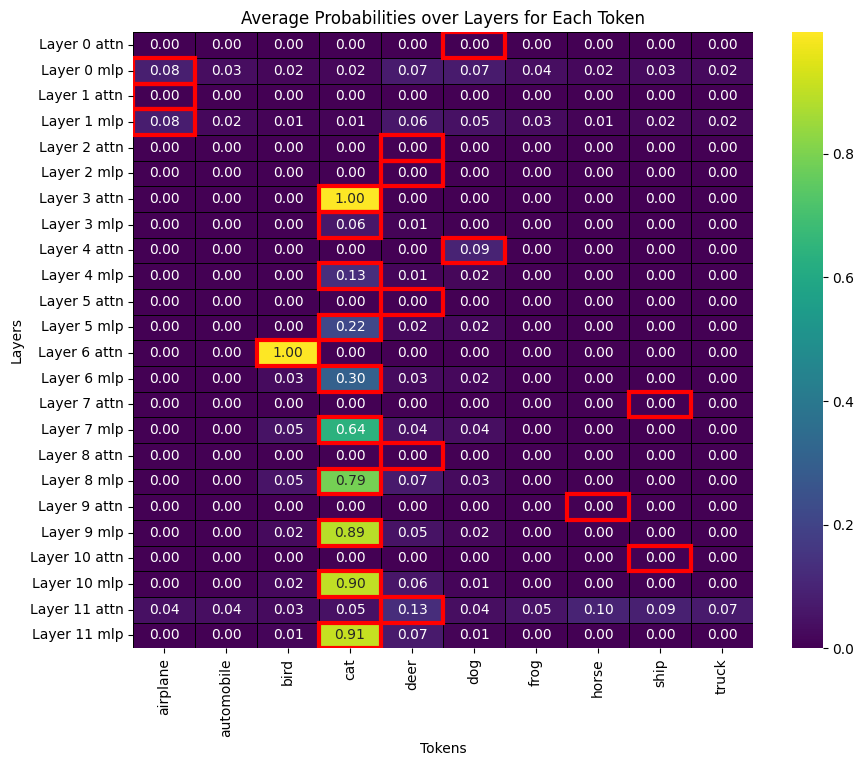

326  cat
1, 0.01
airplane, 0.08
?, 0.00
airplane, 0.08
size, 0.00
deer, 0.00
cat, 1.00
cat, 0.06
dog, 0.09
cat, 0.13
<|endoftext|>, 0.00
cat, 0.22
bird, 1.00
cat, 0.30
automobile, 0.34
cat, 0.64
The, 0.43
cat, 0.79
The, 0.10
cat, 0.89
object, 0.02
cat, 0.90
deer, 0.13
cat, 0.91
1 2


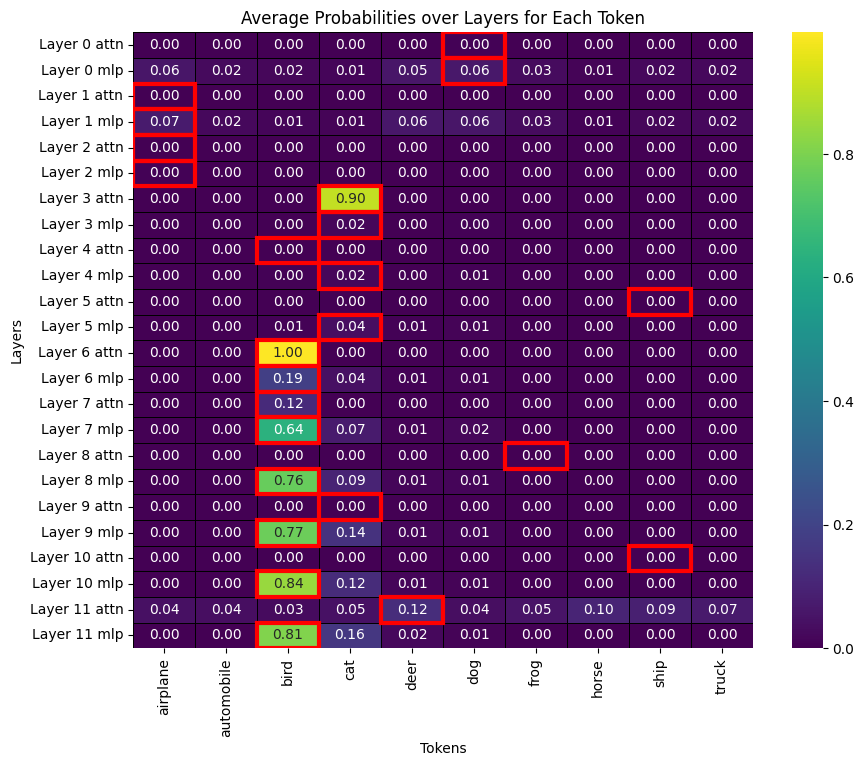

326  cat
1, 0.01
dog, 0.06
?, 0.00
airplane, 0.07
3, 0.00
airplane, 0.00
cat, 0.90
cat, 0.02
']., 0.00
cat, 0.02
in, 0.00
cat, 0.04
bird, 1.00
bird, 0.19
\n, 0.18
bird, 0.64
The, 0.52
bird, 0.76
The, 0.78
bird, 0.77
in, 0.03
bird, 0.84
deer, 0.12
bird, 0.81
2 0


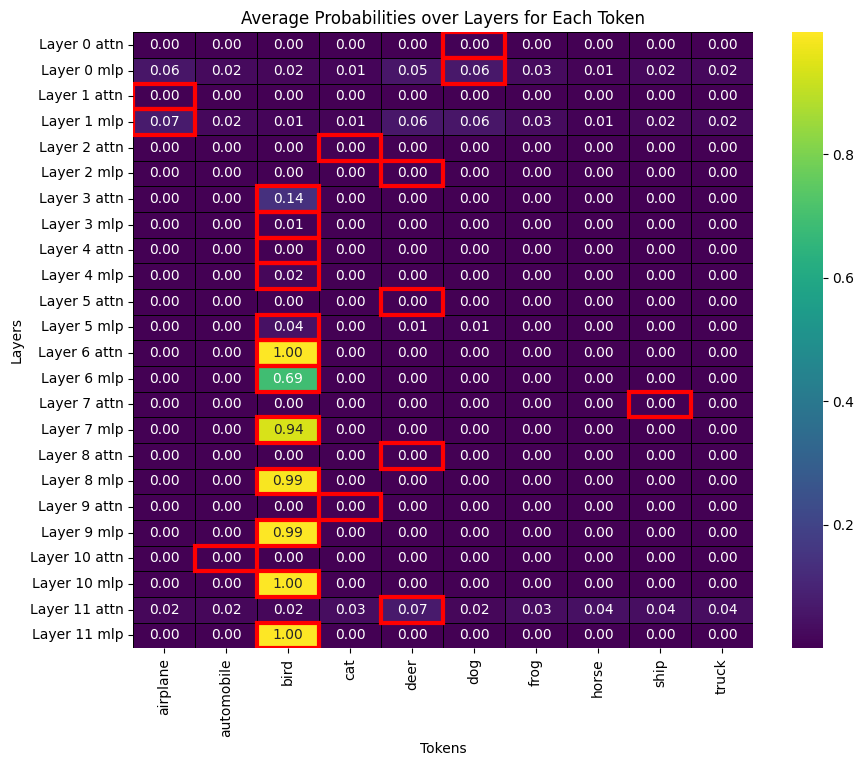

319  bird
1, 0.01
dog, 0.06
?, 0.00
airplane, 0.07
bird, 0.00
deer, 0.00
bird, 0.86
bird, 0.01
']., 0.00
bird, 0.02
in, 0.03
bird, 0.04
bird, 1.00
bird, 0.69
automobile, 0.33
bird, 0.94
grid, 0.08
bird, 0.99
The, 0.45
bird, 0.99
<|endoftext|>, 0.01
bird, 1.00
',, 0.42
bird, 1.00
2 1


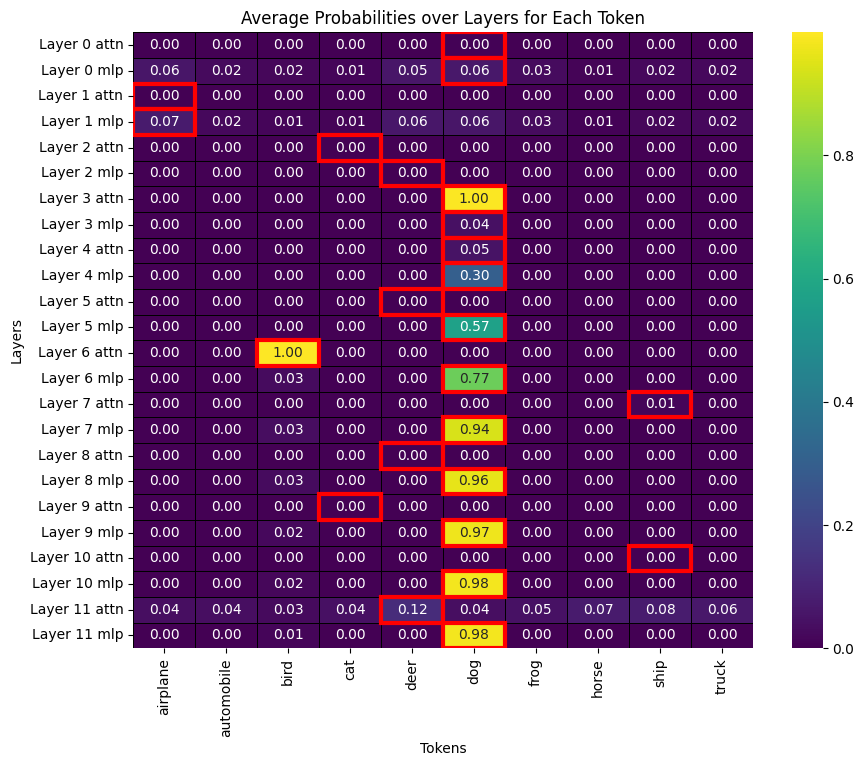

318  dog
1, 0.01
dog, 0.06
?, 0.00
airplane, 0.07
size, 0.00
deer, 0.00
dog, 1.00
dog, 0.04
dog, 0.05
dog, 0.30
in, 0.02
dog, 0.57
bird, 1.00
dog, 0.77
\n, 0.24
dog, 0.94
grid, 0.30
dog, 0.96
The, 0.65
dog, 0.97
in, 0.04
dog, 0.98
',, 0.18
dog, 0.98
2 2


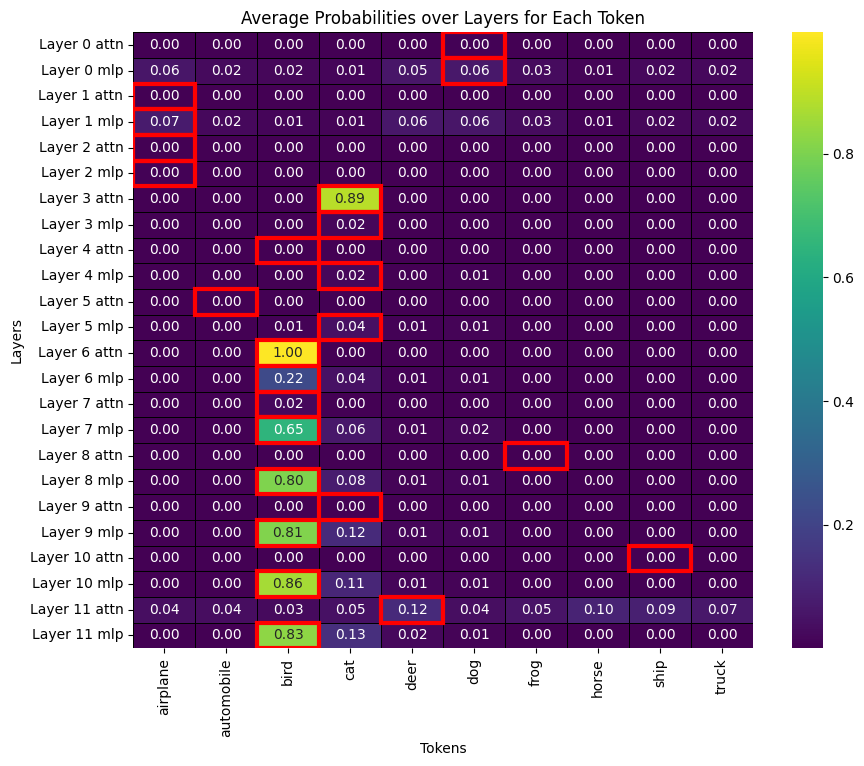

326  cat
1, 0.01
dog, 0.06
?, 0.00
airplane, 0.07
3, 0.00
airplane, 0.00
cat, 0.89
cat, 0.02
']., 0.00
cat, 0.02
in, 0.05
cat, 0.04
bird, 1.00
bird, 0.22
\n, 0.23
bird, 0.65
\n, 0.43
bird, 0.80
The, 0.77
bird, 0.81
in, 0.05
bird, 0.86
',, 0.13
bird, 0.83


In [4]:
print(prompts[0])
for i in range(3):
    for j in range(3):
        print(i, j)
        logit_look(prompt_index=0, row=i, column=j, print_prompt=False, plot=False)